## <span style="color:red"> Run data generation with DARTS</span>

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from darts.hdata.model import Model

## Things to define:
* Number of wells and locations, up to 6 extra wells
* Define controls for wells: rate,

In [68]:
def create_model(X_positions, Y_positions):
    # dimensions for the model
    nx = 230
    ny = 206

    # pre-defined wells - do not change list
#     exist_well_list = ['I01', 'P01', 'I02', 'P02', 'I03', 'P03', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06']
#     exist_well_type = ['INJ', 'PRD', 'INJ', 'PRD', 'INJ', 'PRD', 'EXP', 'EXP', 'EXP', 'EXP', 'EXP', 'EXP']
#     exist_well_x    = [190, 164, 136, 162, 109, 134, 195, 145, 46, 52, 72, 170]
#     exist_well_y    = [100, 110, 75, 87, 113, 115, 70, 41, 46, 100, 152, 170]
    exist_well_list = ['I01', 'P01','I03', 'P03','E05']
    exist_well_type = ['INJ', 'PRD','INJ', 'PRD','EXP']
    exist_well_x    = [190, 164,109, 134,72]
    exist_well_y    = [100, 110,113, 115,152]

    # user introduced wells, up to six extra doublets
    new_well_list = ['I11', 'P12', 'P13', 'I13', 'P14']#E05 should reinject to I11, but I am not sure if darts knows this or how to tell it that.
    new_well_x = X_positions
    new_well_y = Y_positions
    # new_well_x    = [   20,    20,   100,   100,   150,   150, ]
    # new_well_y    = [   20,    40,   100,   120,   150,   170, ]
    n_new_wells = len(new_well_list)

    # define the model
    m = Model()

    # adding new wells to the model
    for i in range(n_new_wells):
        m.add_well(new_well_list[i], new_well_x[i], new_well_y[i])
    
    m.init()
    m.run_python(m.params.first_ts)  # initial run of DARTS
    
    return m

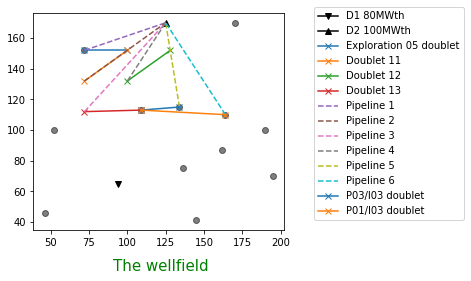

In [69]:
exist_well_x_map    = [190, 164, 136, 162, 109, 134, 195, 145, 46, 52, 72, 170]
exist_well_y_map    = [100, 110, 75, 87, 113, 115, 70, 41, 46, 100, 152, 170]

fig, ax = plt.subplots()
for x,y in zip(exist_well_x_map, exist_well_y_map):
    ax.plot(x,y, marker='o', color='k', alpha=0.5)
    
ax.set_aspect("equal")
ax.plot(94, 65, marker="v", color='k', label = 'D1 80MWth')
ax.plot(125, 170, marker="^", color='k', label='D2 100MWth')


ax.plot([72, 100], [152, 152], marker="x", label="Exploration 05 doublet") #each coordinate digit represents 50m
ax.plot([72, 100], [132, 152], marker="x", label="Doublet 11")#1000m separation
ax.plot([100, 128], [132, 152], marker="x", label="Doublet 12")
ax.plot([72, 109], [112, 113], marker="x", label="Doublet 13")
ax.plot([72, 125], [152, 170], linestyle='--', label="Pipeline 1")
ax.plot([72, 125], [132, 170], linestyle="--", label="Pipeline 2")
ax.plot([72, 125], [112, 170], linestyle="--", label="Pipeline 3")
ax.plot([100, 125], [132, 170], linestyle="--", label="Pipeline 4")
ax.plot([134, 125], [115, 170], linestyle="--", label="Pipeline 5")
# ax.plot([134, 125], [115, 170], linestyle="--", label="Pipeline 6")
ax.plot([164, 125], [110, 170], linestyle="--", label="Pipeline 6")
ax.plot([134, 109], [115, 113], marker="x", label="P03/I03 doublet")
ax.plot([164, 109], [110, 113], marker="x", label="P01/I03 doublet")
ax.text(0.7, -.2, 'The wellfield',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='green', fontsize=15)
ax.legend()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig('wellfield.png', format='png', bbox_inches='tight')


In [70]:
def run_model(m, flow_rate):

    # define controls for all wells
    for i, w in enumerate(m.reservoir.wells):
        # Producers
        if 'P' in w.name:
            m.set_well_control(w, -flow_rate) # rate in m3/day
        # Injectors
        elif 'I' in w.name:
            m.set_well_control(w, flow_rate) # rate in m3/day

#     m.run_python(365, restart_dt=1.36e-6)  # run the first control for 1 year
    m.run_python(50*365)  # ... and the rest for 50 years
    
    return m

In [71]:

def run_sensitivity(X_positions_list, Y_positions_list, flow_rate_list):
    results = []
    
    for X_positions in X_positions_list:
        for Y_positions in Y_positions_list:
            for flow_rate in flow_rate_list:
                m = create_model(X_positions, Y_positions)
                m = run_model(m, flow_rate)
    
                results.append( pd.DataFrame.from_dict(m.physics.engine.time_data))

    return results

In [72]:
# each digit represents 50m
X_positions_list = [
[100,72, 100, 128, 72]
]

Y_positions_list = [
[152, 132, 132, 152, 112]
]#coord 80,144 represents an injection well taking fluids from 2 production wells
#from exploratory analysis, we can achieve 50 year lifetime on well at 1900m depth with flow rate of 1130m3/day and 400m sep.
#maximum necessary years is 30
#no way to control drilling depth
flow_rate_list = [5600, 6000, 6400, 6800, 7200] #from first iteration of 1130, produced ~14MWth after 40 years 1130m3/day/14 = 80*80=6500, account for thermal drawdown 6800

results = run_sensitivity(X_positions_list, Y_positions_list, flow_rate_list)

darts-package built on 02/12/2021 08:37:48 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 0971e97
Reading DX from dap_model.GRDECL.DX.cache... 1421400 values have been read.
Reading DY from dap_model.GRDECL.DY.cache... 1421400 values have been read.
Reading DZ from dap_model.GRDECL.DZ.cache... 1421400 values have been read.
Reading PERMX from dap_model.GRDECL.PERMX.cache... 1421400 values have been read.
Reading PORO from dap_model.GRDECL.PORO.cache... 1421400 values have been read.
Reading DEPTH from dap_model.GRDECL.DEPTH.cache... 1421400 values have been read.
Reading COORD from CASE_GRID.GRDECL.COORD.cache... 286902 values have been read.
Reading ZCORN from CASE_GRID.GRDECL.ZCORN.cache... 11371200 values have been read.
Building connection list...
Applying ACTNUM...
Inactive blocks due to ACTNUM:  631400
Inactive connections due to transmissibility:  0
Inactive connections total:  1186629


KeyboardInterrupt: 

In [78]:
for i, result in enumerate(results):
    result.to_csv('./results/result_' + str(i).zfill(2) +'.csv', index=False)

In [79]:
# from darts.hdata.model import Model

# m = Model()
# time_data = pd.DataFrame.from_dict(m.physics.engine.time_data)#where well controls are saved for every time step
# writer = pd.ExcelWriter('time_data.xlsx')
# time_data.to_excel(writer, 'Sheet1')
# writer.save()

In [80]:
# #plot well regimes and economics
# search_str = 'INJ : water rate'
# ax = time_data.plot(x='time', y=[col for col in time_data.columns if search_str in col])
# plt.show()

# search_str = 'INJ : BHP'
# ax = time_data.plot(x='time', y=[col for col in time_data.columns if search_str in col])
# plt.show()

# search_str = 'PRD : BHP'
# ax = time_data.plot(x='time', y=[col for col in time_data.columns if search_str in col])
# plt.show()

# search_str = 'PRD : temp'
# ax = time_data.plot(x='time', y=[col for col in time_data.columns if search_str in col])
# plt.show()

In [81]:
"""
Script to implement the economic functions with a simple doublet example

SPE Hackathon 2021

author: Alexandros Daniilidis
contact: a.daniilidis@tudelft.nl
"""
#I have no idea why the dictionary is not being written like the example shown in the classes
#c 3 and p 3 are appearing as leading values in the key: value pairs and it is a mess. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load example simulation data

data = pd.read_csv('results/result_00.csv')

data.head()

,P14 : BHP (bar),P14 : p 19 reservoir P (bar),P14 : p 19 c 1 rate (Kmol/day),P14 : p 19 c 0 rate (Kmol/day),P14 : p 18 reservoir P (bar),P14 : p 18 c 1 rate (Kmol/day),P14 : p 18 c 0 rate (Kmol/day),P14 : p 17 c 1 rate (Kmol/day),P14 : p 17 c 0 rate (Kmol/day),P14 : p 15 c 1 rate (Kmol/day),...,P14 : p 7 c 1 rate (Kmol/day),P14 : p 7 reservoir P (bar),E05 : p 15 reservoir P (bar),P14 : p 8 c 1 rate (Kmol/day),I11 : p 7 reservoir P (bar),P12 : p 12 reservoir P (bar),P14 : p 9 c 0 rate (Kmol/day),P01 : p 12 reservoir P (bar),I11 : p 5 reservoir P (bar),P14 : p 9 c 1 rate (Kmol/day)
0,204.553512,212.019265,-17402.236934,-6.954703e+07,211.241947,-16448.578303,-6.624391e+07,-6327.062585,-2.528490e+07,-3703.248658,...,83886.413669,202.679196,196.202247,62000.838329,187.125169,180.065977,6.074717e+01,233.063483,186.149614,20770.589777
1,202.049760,212.009603,-23171.908188,-9.260518e+07,211.234246,-22540.683262,-9.077884e+07,-8983.703749,-3.590166e+07,-5816.012772,...,-6737.607764,202.683038,196.198499,-16785.144633,187.126629,180.065905,-1.353776e+08,233.047277,186.152026,-33880.115004
2,201.946142,211.860117,-23064.672253,-9.217665e+07,211.116640,-22505.974615,-9.063876e+07,-9042.284394,-3.613574e+07,-5884.261717,...,-8308.398311,202.722805,196.141428,-17343.200691,187.161373,180.064246,-1.327993e+08,232.846349,186.197648,-33234.873810
3,201.095261,210.321902,-21462.182584,-8.577227e+07,209.929586,-21679.128566,-8.730576e+07,-9122.889269,-3.645743e+07,-6309.778414,...,-15389.228094,202.517820,195.601010,-19749.134314,187.990751,179.968795,-1.194468e+08,231.512494,187.102054,-29893.353997
4,198.966617,206.432805,-17359.136520,-6.936767e+07,206.502601,-18485.825692,-7.444779e+07,-7889.969679,-3.152737e+07,-6571.915957,...,-21515.683919,200.947947,194.704292,-22290.725492,191.629862,177.489420,-1.129760e+08,228.489555,191.328979,-28273.169671


In [82]:
data.columns.tolist()

['P14 : BHP (bar)',
 'P14 : p 19 reservoir P (bar)',
 'P14 : p 19 c 1 rate (Kmol/day)',
 'P14 : p 19 c 0 rate (Kmol/day)',
 'P14 : p 18 reservoir P (bar)',
 'P14 : p 18 c 1 rate (Kmol/day)',
 'P14 : p 18 c 0 rate (Kmol/day)',
 'P14 : p 17 c 1 rate (Kmol/day)',
 'P14 : p 17 c 0 rate (Kmol/day)',
 'P14 : p 15 c 1 rate (Kmol/day)',
 'P14 : p 14 c 1 rate (Kmol/day)',
 'P14 : p 14 c 0 rate (Kmol/day)',
 'P14 : p 13 c 1 rate (Kmol/day)',
 'P14 : p 13 c 0 rate (Kmol/day)',
 'P14 : p 12 reservoir P (bar)',
 'P14 : p 12 c 1 rate (Kmol/day)',
 'P14 : p 12 c 0 rate (Kmol/day)',
 'P14 : p 11 c 0 rate (Kmol/day)',
 'P14 : p 10 reservoir P (bar)',
 'P14 : p 10 c 1 rate (Kmol/day)',
 'P14 : p 10 c 0 rate (Kmol/day)',
 'E02 : p 19 c 0 rate (Kmol/day)',
 'E02 : p 18 reservoir P (bar)',
 'P02 : p 13 c 0 rate (Kmol/day)',
 'E02 : p 17 reservoir P (bar)',
 'E06 : p 6 c 0 rate (Kmol/day)',
 'E02 : p 17 c 1 rate (Kmol/day)',
 'E01 : p 17 c 0 rate (Kmol/day)',
 'E02 : p 16 reservoir P (bar)',
 'I13 : p 11 c 

In [83]:
# list the collumn names that should be removed
press_gridcells = data.filter(like='reservoir').columns.tolist()
chem_cols = data.filter(like='kmol/day').columns.tolist()

# remove collumns from data
data.drop(columns=press_gridcells + chem_cols,inplace=True)

data

,P14 : BHP (bar),P14 : p 19 c 1 rate (Kmol/day),P14 : p 19 c 0 rate (Kmol/day),P14 : p 18 c 1 rate (Kmol/day),P14 : p 18 c 0 rate (Kmol/day),P14 : p 17 c 1 rate (Kmol/day),P14 : p 17 c 0 rate (Kmol/day),P14 : p 15 c 1 rate (Kmol/day),P14 : p 14 c 1 rate (Kmol/day),P14 : p 14 c 0 rate (Kmol/day),...,P14 : p 4 c 0 rate (Kmol/day),I02 : p 15 c 0 rate (Kmol/day),P14 : p 6 c 0 rate (Kmol/day),E05 : p 15 c 0 rate (Kmol/day),P14 : p 7 c 0 rate (Kmol/day),I13 : c 0 rate (Kmol/day),P14 : p 7 c 1 rate (Kmol/day),P14 : p 8 c 1 rate (Kmol/day),P14 : p 9 c 0 rate (Kmol/day),P14 : p 9 c 1 rate (Kmol/day)
0,204.553512,-17402.236934,-6.954703e+07,-16448.578303,-6.624391e+07,-6327.062585,-2.528490e+07,-3703.248658,-59.236536,-238549.603250,...,1.316487e+01,-584390.589331,3.609455e+01,-2.819717e+07,2.453403e+02,0.000000e+00,83886.413669,62000.838329,6.074717e+01,20770.589777
1,202.049760,-23171.908188,-9.260518e+07,-22540.683262,-9.077884e+07,-8983.703749,-3.590166e+07,-5816.012772,-100.415734,-404381.275059,...,5.412959e+00,18.876208,2.354733e+00,-2.836865e+07,-2.692114e+07,1.399085e+09,-6737.607764,-16785.144633,-1.353776e+08,-33880.115004
2,201.946142,-23064.672253,-9.217665e+07,-22505.974615,-9.063876e+07,-9042.284394,-3.613574e+07,-5884.261717,-102.110268,-411206.779309,...,5.086128e+00,32.815574,6.667918e-01,-2.792848e+07,-3.319747e+07,1.399082e+09,-8308.398311,-17343.200691,-1.327993e+08,-33234.873810
3,201.095261,-21462.182584,-8.577227e+07,-21679.128566,-8.730576e+07,-9122.889269,-3.645743e+07,-6309.778414,-115.719370,-466011.540255,...,2.420262e+00,39.189082,-3.585240e+06,-2.370605e+07,-6.148985e+07,1.399075e+09,-15389.228094,-19749.134314,-1.194468e+08,-29893.353997
4,198.966617,-17359.136520,-6.936767e+07,-18485.825692,-7.444779e+07,-7889.969679,-3.152737e+07,-6571.915957,-135.733054,-546652.862926,...,-9.272469e+05,39.386402,-7.594073e+06,-1.533267e+07,-8.597115e+07,1.399077e+09,-21515.683919,-22290.725492,-1.129760e+08,-28273.169671
5,196.206355,-14743.453181,-5.890936e+07,-15862.179739,-6.391196e+07,-6757.168891,-2.699930e+07,-6076.009056,-102.428655,-412736.583327,...,-2.528683e+06,40.734299,-8.525458e+06,-7.210208e+06,-9.326592e+07,1.399168e+09,-23337.947612,-23347.051915,-1.135485e+08,-28413.376244
6,194.895722,-9988.493465,-3.994175e+07,-10748.173371,-4.330051e+07,-4563.775854,-1.825064e+07,-4080.667227,-68.146131,-274561.450272,...,-3.372390e+06,41.737310,-9.905619e+06,1.964904e+00,-1.061893e+08,1.401566e+09,-26544.919138,-26685.274703,-1.302755e+08,-32567.918553
7,196.903342,-8980.878151,-3.597448e+07,-9660.915637,-3.884484e+07,-4080.599468,-1.634671e+07,-3563.764289,-62.193980,-250092.281889,...,-3.314969e+06,42.160953,-1.012567e+07,1.168003e+00,-1.085532e+08,1.403031e+09,-27087.976475,-27558.476016,-1.361311e+08,-33971.989368
8,194.082409,-8944.087258,-3.581936e+07,-9608.901257,-3.857765e+07,-4060.635906,-1.626296e+07,-3535.585782,-61.916277,-248599.089383,...,-3.302304e+06,42.205986,-1.014775e+07,9.612185e-01,-1.089917e+08,1.401835e+09,-27203.736836,-27704.439663,-1.372471e+08,-34258.527521
9,193.456592,-8965.635668,-3.589989e+07,-9616.634444,-3.860191e+07,-4070.703777,-1.630054e+07,-3544.295739,-61.973249,-248782.687518,...,-3.308171e+06,42.227004,-1.016708e+07,9.576540e-01,-1.093349e+08,1.400681e+09,-27294.260061,-27761.407461,-1.377119e+08,-34380.554080


In [84]:
data['Time (yrs)'] = data['time']/365
data['Time (yrs)']

0     2.739726e-09
1     6.465016e-09
2     6.606966e-08
3     1.019744e-06
4     1.627853e-05
5     2.604192e-04
6     4.166669e-03
7     6.666667e-02
8     1.066667e+00
9     2.066667e+00
10    3.066667e+00
11    4.066667e+00
12    5.066667e+00
13    6.066667e+00
14    7.066667e+00
15    8.066667e+00
16    9.066667e+00
17    1.006667e+01
18    1.106667e+01
19    1.206667e+01
20    1.306667e+01
21    1.406667e+01
22    1.506667e+01
23    1.606667e+01
24    1.706667e+01
25    1.806667e+01
26    1.906667e+01
27    2.006667e+01
28    2.106667e+01
29    2.206667e+01
30    2.306667e+01
31    2.406667e+01
32    2.506667e+01
33    2.606667e+01
34    2.706667e+01
35    2.806667e+01
36    2.906667e+01
37    3.006667e+01
38    3.106667e+01
39    3.206667e+01
40    3.306667e+01
41    3.406667e+01
42    3.506667e+01
43    3.606667e+01
44    3.706667e+01
45    3.806667e+01
46    3.906667e+01
47    4.006667e+01
48    4.106667e+01
49    4.206667e+01
50    4.306667e+01
51    4.406667e+01
52    4.5066

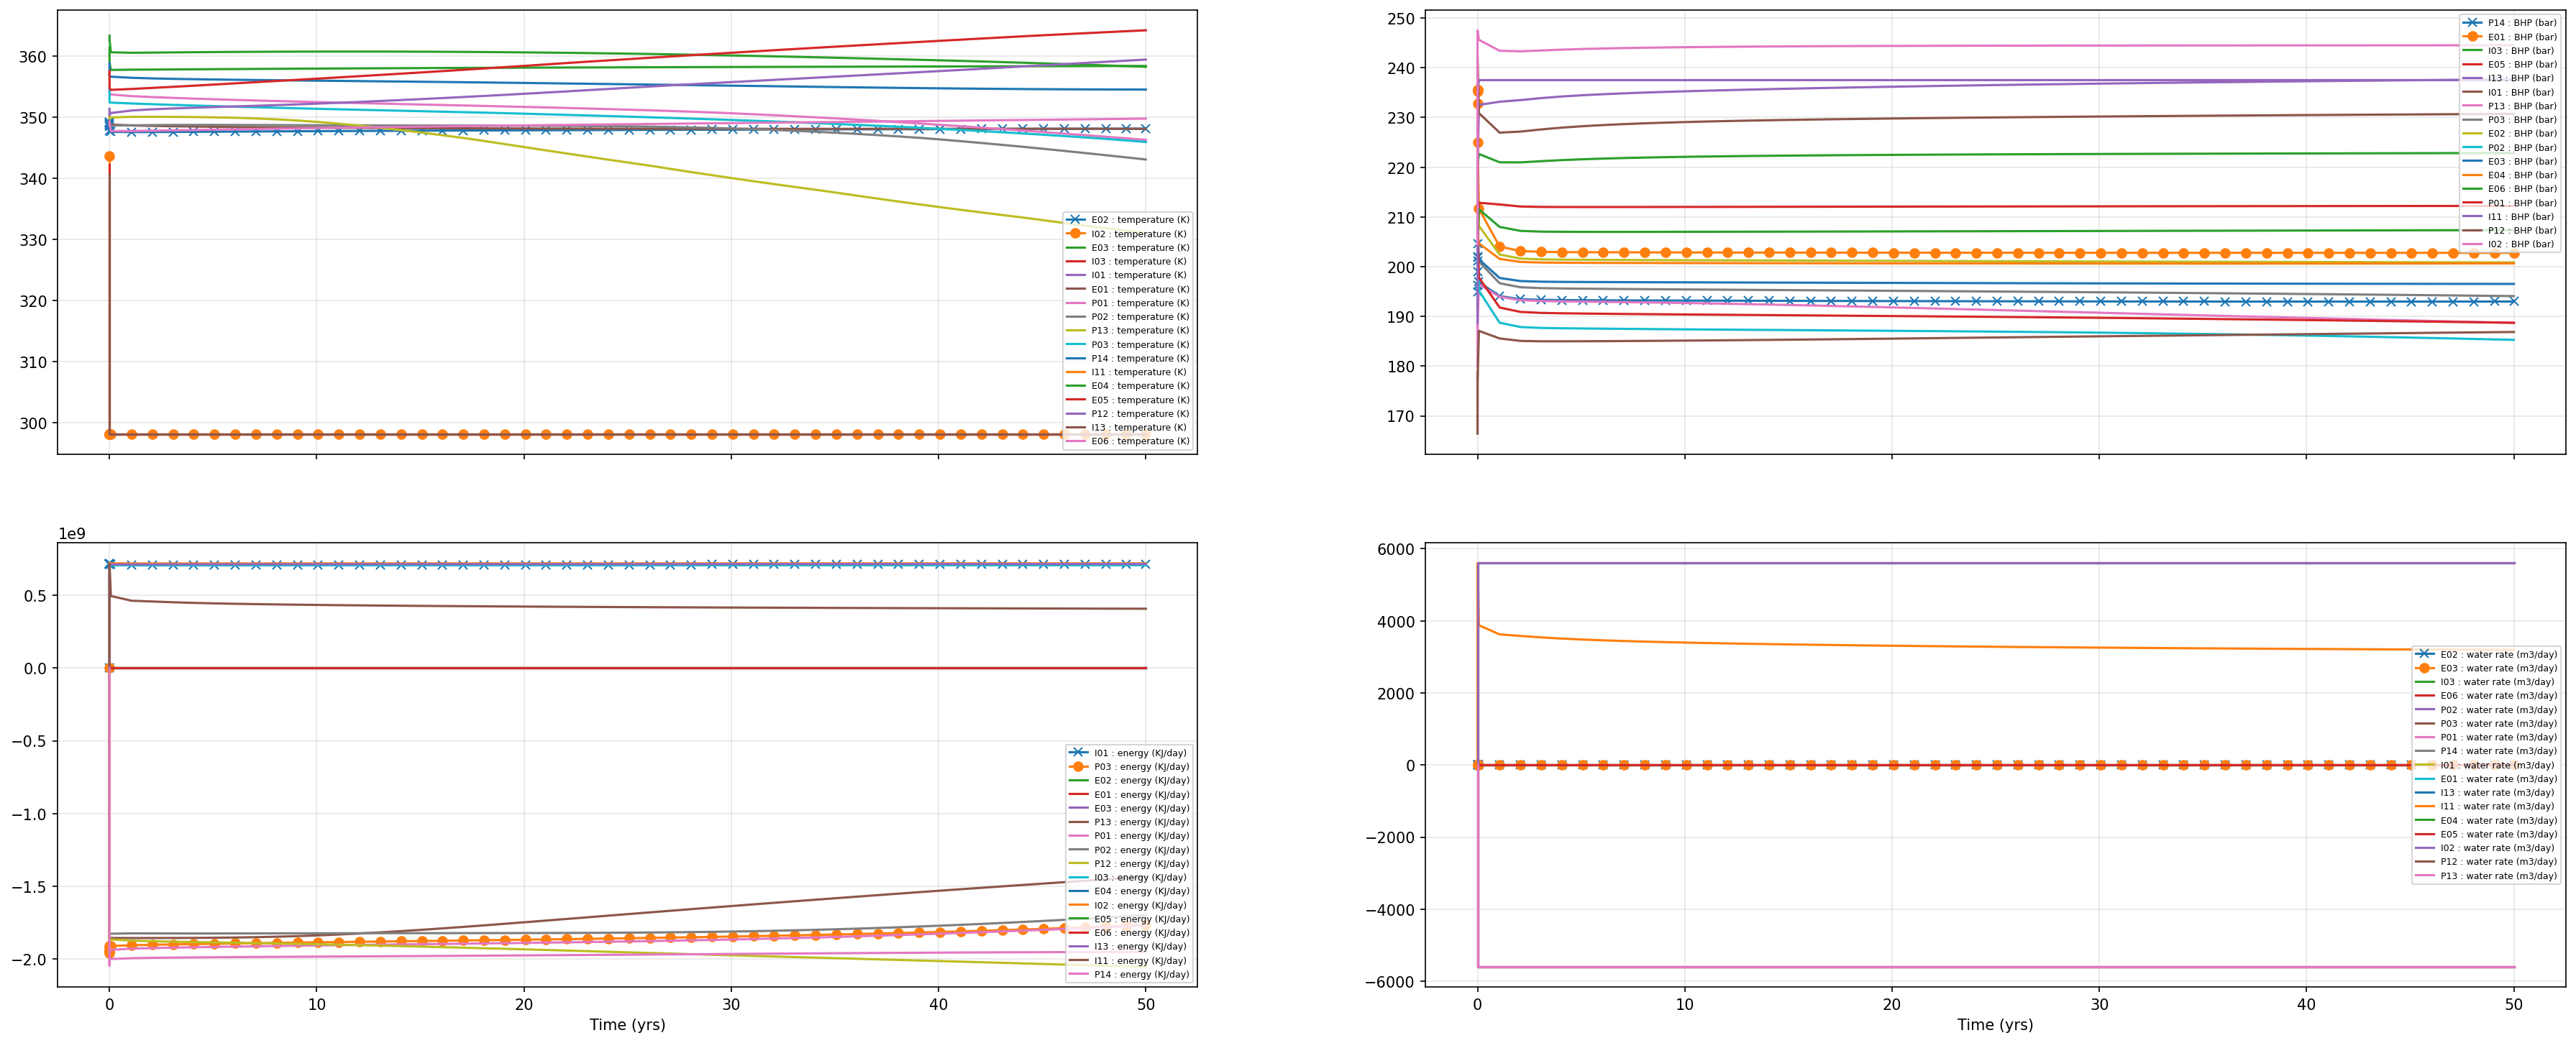

In [85]:
# do a first plot to get an overview of our data
# define a plot
fig, ax = plt.subplots(2,2, figsize=(30,12), dpi=150, sharex=True)
# get plot axes
ax_list = fig.axes

# plot a few keywords in pairs for both wells
for i, key in enumerate(['temperature (K)', 'BHP (bar)','energy (KJ/day)','water rate (m3/day)']):
    data.plot(x='Time (yrs)',
              y=data.filter(like=key).columns.tolist(),
              ax=ax_list[i],
              linestyle='-',
              style=['x', 'o'])
    ax_list[i].legend(fontsize=6)
    ax_list[i].grid(alpha=0.3)

plt.show()

In [86]:
data['Datetime'] = pd.to_datetime('1/1/2000') + pd.to_timedelta(
    data['Time (yrs)'] * pd.Timedelta(('365 days')), unit = 's')
data.set_index('Datetime', inplace=True)

set_interval = '365D'

resample_index = pd.date_range(data.index[0] - pd.Timedelta(set_interval),
                              data.index[-1] + pd.Timedelta(set_interval), freq=set_interval, normalize=True,
                               closed = 'right')


In [87]:
tdata = data.reindex(data.index.union(resample_index)).interpolate('index').reindex(resample_index)

tdata.iloc[0] = data.iloc[0]
tdata.iloc[-1]= data.iloc[-1]

tdata['econ_periods'] = np.arange(len(tdata))

In [88]:
tdata

,P14 : BHP (bar),P14 : p 19 c 1 rate (Kmol/day),P14 : p 19 c 0 rate (Kmol/day),P14 : p 18 c 1 rate (Kmol/day),P14 : p 18 c 0 rate (Kmol/day),P14 : p 17 c 1 rate (Kmol/day),P14 : p 17 c 0 rate (Kmol/day),P14 : p 15 c 1 rate (Kmol/day),P14 : p 14 c 1 rate (Kmol/day),P14 : p 14 c 0 rate (Kmol/day),...,P14 : p 6 c 0 rate (Kmol/day),E05 : p 15 c 0 rate (Kmol/day),P14 : p 7 c 0 rate (Kmol/day),I13 : c 0 rate (Kmol/day),P14 : p 7 c 1 rate (Kmol/day),P14 : p 8 c 1 rate (Kmol/day),P14 : p 9 c 0 rate (Kmol/day),P14 : p 9 c 1 rate (Kmol/day),Time (yrs),econ_periods
2000-01-01,204.553512,-17402.236934,-6.954703e+07,-16448.578303,-6.624391e+07,-6327.062585,-2.528490e+07,-3703.248658,-59.236536,-238549.603250,...,3.609455e+01,-2.819717e+07,2.453403e+02,0.000000e+00,83886.413669,62000.838329,6.074717e+01,20770.589777,2.739726e-09,0
2000-12-31,194.270471,-8946.539984,-3.582970e+07,-9612.368882,-3.859546e+07,-4061.966810,-1.626854e+07,-3537.464349,-61.934791,-248698.635554,...,-1.014628e+07,9.750042e-01,-1.089625e+08,1.401915e+09,-27196.019478,-27694.708753,-1.371727e+08,-34239.424977,1.000000e+00,1
2001-12-31,193.498313,-8964.199108,-3.589452e+07,-9616.118898,-3.860029e+07,-4070.032586,-1.629804e+07,-3543.715076,-61.969451,-248770.447642,...,-1.016579e+07,9.578917e-01,-1.093120e+08,1.400758e+09,-27288.225179,-27757.609607,-1.376809e+08,-34372.418976,2.000000e+00,2
2002-12-31,193.329252,-8985.986932,-3.597860e+07,-9624.075560,-3.863038e+07,-4080.181830,-1.633717e+07,-3552.666224,-62.031854,-249007.602902,...,-1.018258e+07,9.571616e-01,-1.096319e+08,1.399455e+09,-27370.969415,-27802.867377,-1.380841e+08,-34476.574200,3.000000e+00,3
2003-12-31,193.278151,-9006.581851,-3.605864e+07,-9631.077077,-3.865782e+07,-4089.707607,-1.637418e+07,-3561.070505,-62.089765,-249234.340760,...,-1.019692e+07,9.574191e-01,-1.099304e+08,1.398005e+09,-27447.787294,-27841.143044,-1.384550e+08,-34571.952028,4.000000e+00,4
2004-12-30,193.252007,-9025.974976,-3.613409e+07,-9637.250440,-3.868217e+07,-4098.644705,-1.640893e+07,-3568.949336,-62.142224,-249440.743127,...,-1.020945e+07,9.581461e-01,-1.102119e+08,1.396440e+09,-27520.211934,-27874.770401,-1.388044e+08,-34661.773516,5.000000e+00,5
2005-12-30,193.233180,-9044.351578,-3.620560e+07,-9642.849894,-3.870427e+07,-4107.105993,-1.644184e+07,-3576.410255,-62.190073,-249629.161734,...,-1.022059e+07,9.592568e-01,-1.104792e+08,1.394810e+09,-27588.971121,-27904.854394,-1.391367e+08,-34747.175664,6.000000e+00,6
2006-12-30,193.217579,-9061.875557,-3.627379e+07,-9648.071579,-3.872489e+07,-4115.179165,-1.647324e+07,-3583.534486,-62.234317,-249803.382986,...,-1.023066e+07,9.606711e-01,-1.107344e+08,1.393144e+09,-27654.632560,-27932.229893,-1.394545e+08,-34828.885177,7.000000e+00,7
2007-12-30,193.203793,-9078.682342,-3.633919e+07,-9653.052950,-3.874456e+07,-4122.929667,-1.650339e+07,-3590.380166,-62.275749,-249966.371135,...,-1.023989e+07,9.623119e-01,-1.109793e+08,1.391457e+09,-27717.630263,-27957.497913,-1.397600e+08,-34907.410850,8.000000e+00,8
2008-12-29,193.191229,-9094.891212,-3.640228e+07,-9657.901601,-3.876370e+07,-4130.411581,-1.653250e+07,-3596.993150,-62.315185,-250121.539853,...,-1.024850e+07,9.641182e-01,-1.112153e+08,1.389764e+09,-27778.336138,-27981.119879,-1.400544e+08,-34983.094951,9.000000e+00,9


In [89]:
#calculate the difference in hours between timesteps
tdata['Deltahours'] = tdata.index.to_series().diff(1) / pd.Timedelta('1 hour')

tdata['Deltahours'].unique()
# tdata['P12: energy (KJ/day)']

array([  nan, 8760.])

In [90]:
#recompute time columns based on index
tdata['Time (yrs)'] = pd.to_timedelta(tdata.index - tdata.index[0]).total_seconds() / (365*24*60*60)
                                      
#reset index to time delta
tdata.set_index(pd.to_timedelta(tdata['Time (yrs)'] * pd.Timedelta(('365 days')), unit='s'), inplace=True)
tdata.drop(columns='time', inplace = True)

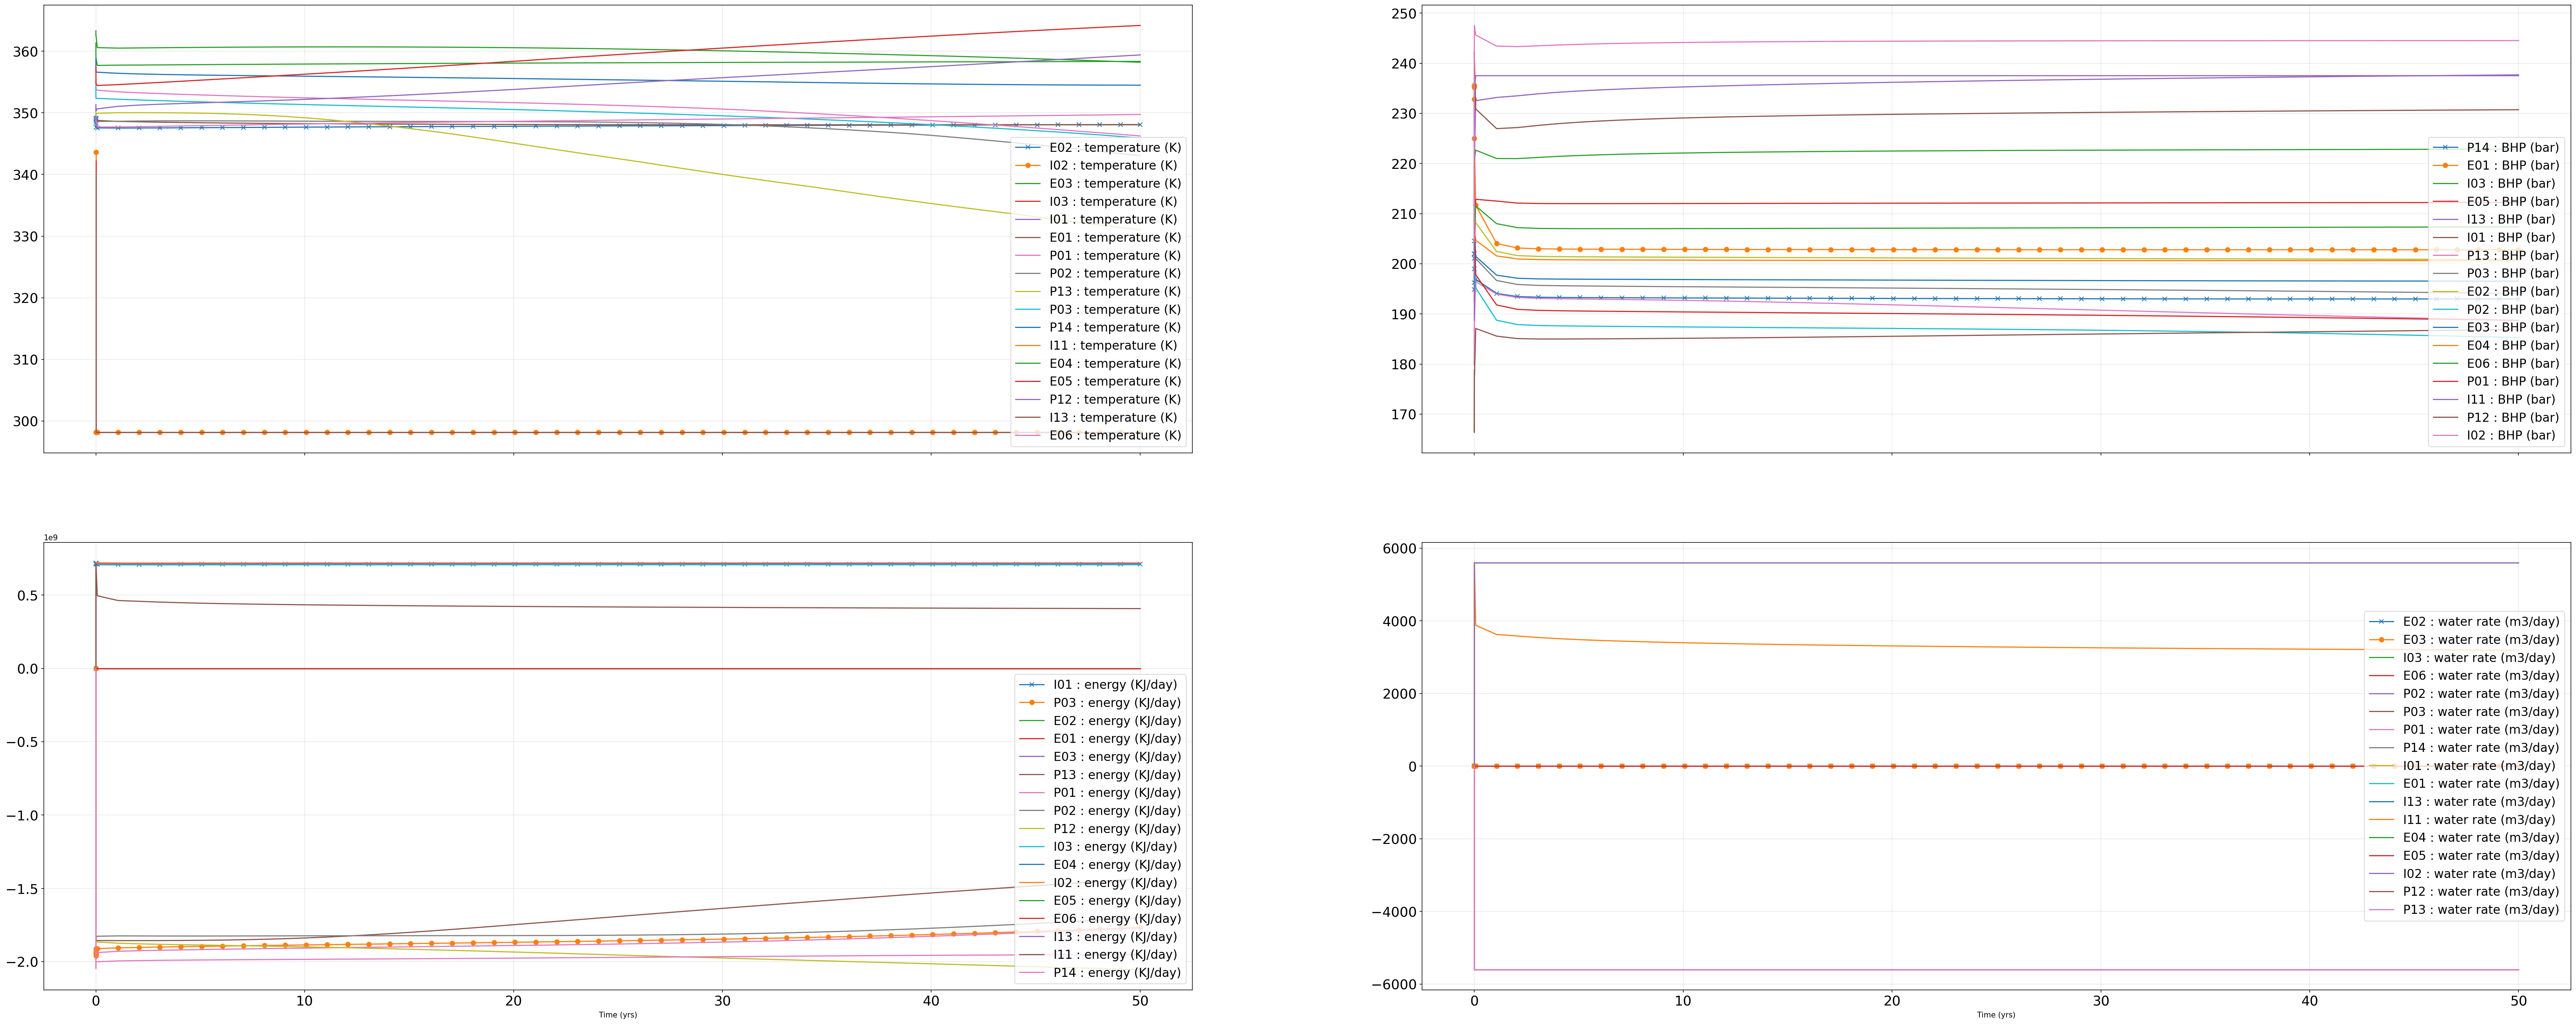

In [91]:
# define a plot
fig, ax = plt.subplots(2,2, figsize=(60,24), dpi=150, sharex=True)
# get plot axes
ax_list = fig.axes

# plot a few keywords in pairs for both wells
for i, key in enumerate(['temperature (K)', 'BHP (bar)','energy (KJ/day)','water rate (m3/day)']):
    data.plot(x='Time (yrs)',
              y=data.filter(like=key).columns.tolist(),
              ax=ax_list[i],
              linestyle='-',
              style=['x', 'o'],
              fontsize=18
             )
    ax_list[i].legend(fontsize=16)
    ax_list[i].grid(alpha=0.3)

plt.show()

<AxesSubplot:xlabel='Time (yrs)'>

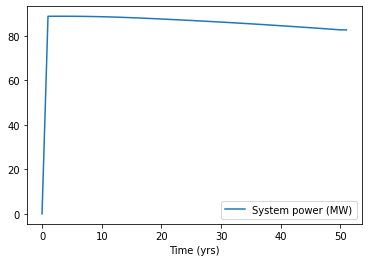

In [92]:
kJ_day_MW = 1/3.6e6/24
#these were the wells we actually want to use:
# 'I11', 'P12', 'I12', 'P13', 'I13', 'P14', 'E05', 'P03', 'P01', 'I03'
#compute system power
tdata['System power (MW)'] = (abs(tdata["P12 : energy (KJ/day)"]+tdata['P13 : energy (KJ/day)']+tdata['P14 : energy (KJ/day)']+tdata['P03 : energy (KJ/day)']+tdata['P01 : energy (KJ/day)'])
                             - abs(tdata['I11 : energy (KJ/day)']+tdata['I13 : energy (KJ/day)']+tdata['I03 : energy (KJ/day)'])) * kJ_day_MW
#note 4186.8 KJ/Kmol
#compute produced power
tdata['Produced Energy (MWh)'] = tdata['System power (MW)'] * tdata['Deltahours']

tdata.plot('Time (yrs)', 'System power (MW)')


In [93]:
#compute pressured drop
tdata['Pump dp (MPa)'] = abs(tdata["P12 : BHP (bar)"]+tdata['P13 : BHP (bar)']+tdata['P14 : BHP (bar)']+tdata['P03 : BHP (bar)']+tdata['P01 : BHP (bar)'] *0.1) - abs(tdata['I11 : BHP (bar)']+tdata['I13 : BHP (bar)']+tdata['I03 : BHP (bar)'] *0.1)

In [94]:
m3_day_m3_sec = 1 / (24*60*60)
pump_efficiency = 0.5

tdata['Pump power (MW)'] = abs(tdata['Pump dp (MPa)']) * abs(tdata['I11 : water rate (m3/day)']+tdata['I13 : water rate (m3/day)']+tdata['I03 : water rate (m3/day)'])* m3_day_m3_sec * pump_efficiency

#compute pumping costs
electricity_price = 100 #euro/MWh
tdata['OpEx_pump (\u20ac)'] = tdata['Pump power (MW)'] * tdata['Deltahours'] * electricity_price

In [141]:
def drillingcostnl(depth):
    """
    Calculate the cost of drilling as a function of depth
    Reference source:
        http://www.thermogis.nl/en/economic-model
        
    :param depth: float
        measured depth along hole in meters
    
    :return: float
        costs in euros
    """
    drilling_cost_nl = 375000 + 1150 * depth + 0.3 * depth ** 2
    return(drilling_cost_nl)
#how do we determine how deep the wells have been drilled? BHP is a guess
depth = 2355 #assuming 212 bar average at hydrostatic
drill_well = drillingcostnl(depth)
#costs of stuff
surf_piping_capex= 600000 #per km
surf_piping_opex = 50000 #per km (this is about 2.7% in real life.)
hex_capex = 2000000
hex_opex = 10000
filter_bag_capex = 4500
filter_bag_opex = 70000
inj_pump_capex = 300000 #replaced every 5 years
inj_pump_opex = 15000
esp_capex= 400000 
christ_tree_capex=250000 #wellhead
christ_opex=10000
degasser_capex= 1000000
degasser_opex=15000
esp_replace = 300000 #replaced every 3 years

#assign capex for drilling the wells
tdata['CapEx (\u20ac)'] = 0
tdata.loc[tdata.index == tdata.index[0], 'CapEx (\u20ac)'] = 2* 4113000

# tdata['Pump power(MW)'] * tdata['Deltahours'] * electricity_price
periodic_OpEx_rate = 0.07

#calc var OpEx costs
tdata['OpEx (\u20ac)'] = tdata['CapEx (\u20ac)'].cumsum()* periodic_OpEx_rate



In [151]:
#calculate cost of distribution system and other stuff
dist_pipe1 = np.sqrt((125-72)^2 + (170-152)^2)*50
dist_pipe2 = np.sqrt((125-72)^2 + (170-132)^2)*50
dist_pipe3 = np.sqrt((125-72)^2 + (170-112)^2)*50
dist_pipe4 = np.sqrt((125-100)^2 + (170-132)^2)*50
dist_pipe5 = np.sqrt((134-125)^2 + (170-115)^2)*50 
dist_pipe6 = np.sqrt((164-125)^2 + (170-110)^2)*50 #[164, 125], [110, 170]

pipe_dist = (dist_pipe1+dist_pipe2+dist_pipe3+dist_pipe4+dist_pipe5+dist_pipe6)/1000
pipe_cost = pipe_dist*surf_piping_capex
hex_cost = hex_capex*6 #six doublets
inj_pump_cost = 3*inj_pump_capex #3 injection wells
christ_cost = christ_tree_capex*3 #3 existing production wells, 3 require christ tree
degasser_cost = 6*degasser_capex #6 doublets
filter_cost = filter_bag_capex*6
esp_cost = 3*esp_capex #3 new production wells
drill_cost = drill_well * 5 #five new wells
                                                                       
#calculate LCOH
periodic_discount_rate = 0.05

#costs
tdata['LCOH costs'] = tdata['CapEx (\u20ac)'].fillna(0) \
    + tdata['CapEx (\u20ac)'] \
    +(((50/3)*esp_replace))\
    +(50*(surf_piping_opex*pipe_dist)\
    +(50*hex_opex)+(50*filter_bag_opex)\
    +(50*inj_pump_opex)+(50*degasser_opex)\
    +((50/5)*inj_pump_capex)\
    +(50*christ_opex)\
    +(pipe_cost+hex_cost+inj_pump_cost+christ_cost+degasser_cost+filter_cost+esp_cost+drill_cost))\
    + tdata['OpEx_pump (\u20ac)'].fillna(0)\

#discount LCOH
tdata['discounted LCOH costs'] = (tdata['LCOH costs'])\
    / (1 + periodic_discount_rate) ** tdata['econ_periods'].cumsum()

tdata['discounted LCOH energy'] = (tdata['Produced Energy (MWh)'].cumsum() /
                                  (1 + periodic_discount_rate) ** tdata['econ_periods']).cumsum()

tdata[r'LCOH (€/MWh)'] = tdata['discounted LCOH costs'] / tdata['discounted LCOH energy']

print('The total capital costs of the system is ' + str(tdata['LCOH costs'][0]) + ' euros.')
# tdata['LCOH costs'][0]

The total capital costs of the system is 80366700.727907 euros.


In [136]:
# data.dtypes
# data.head()
# data['Time (y)']

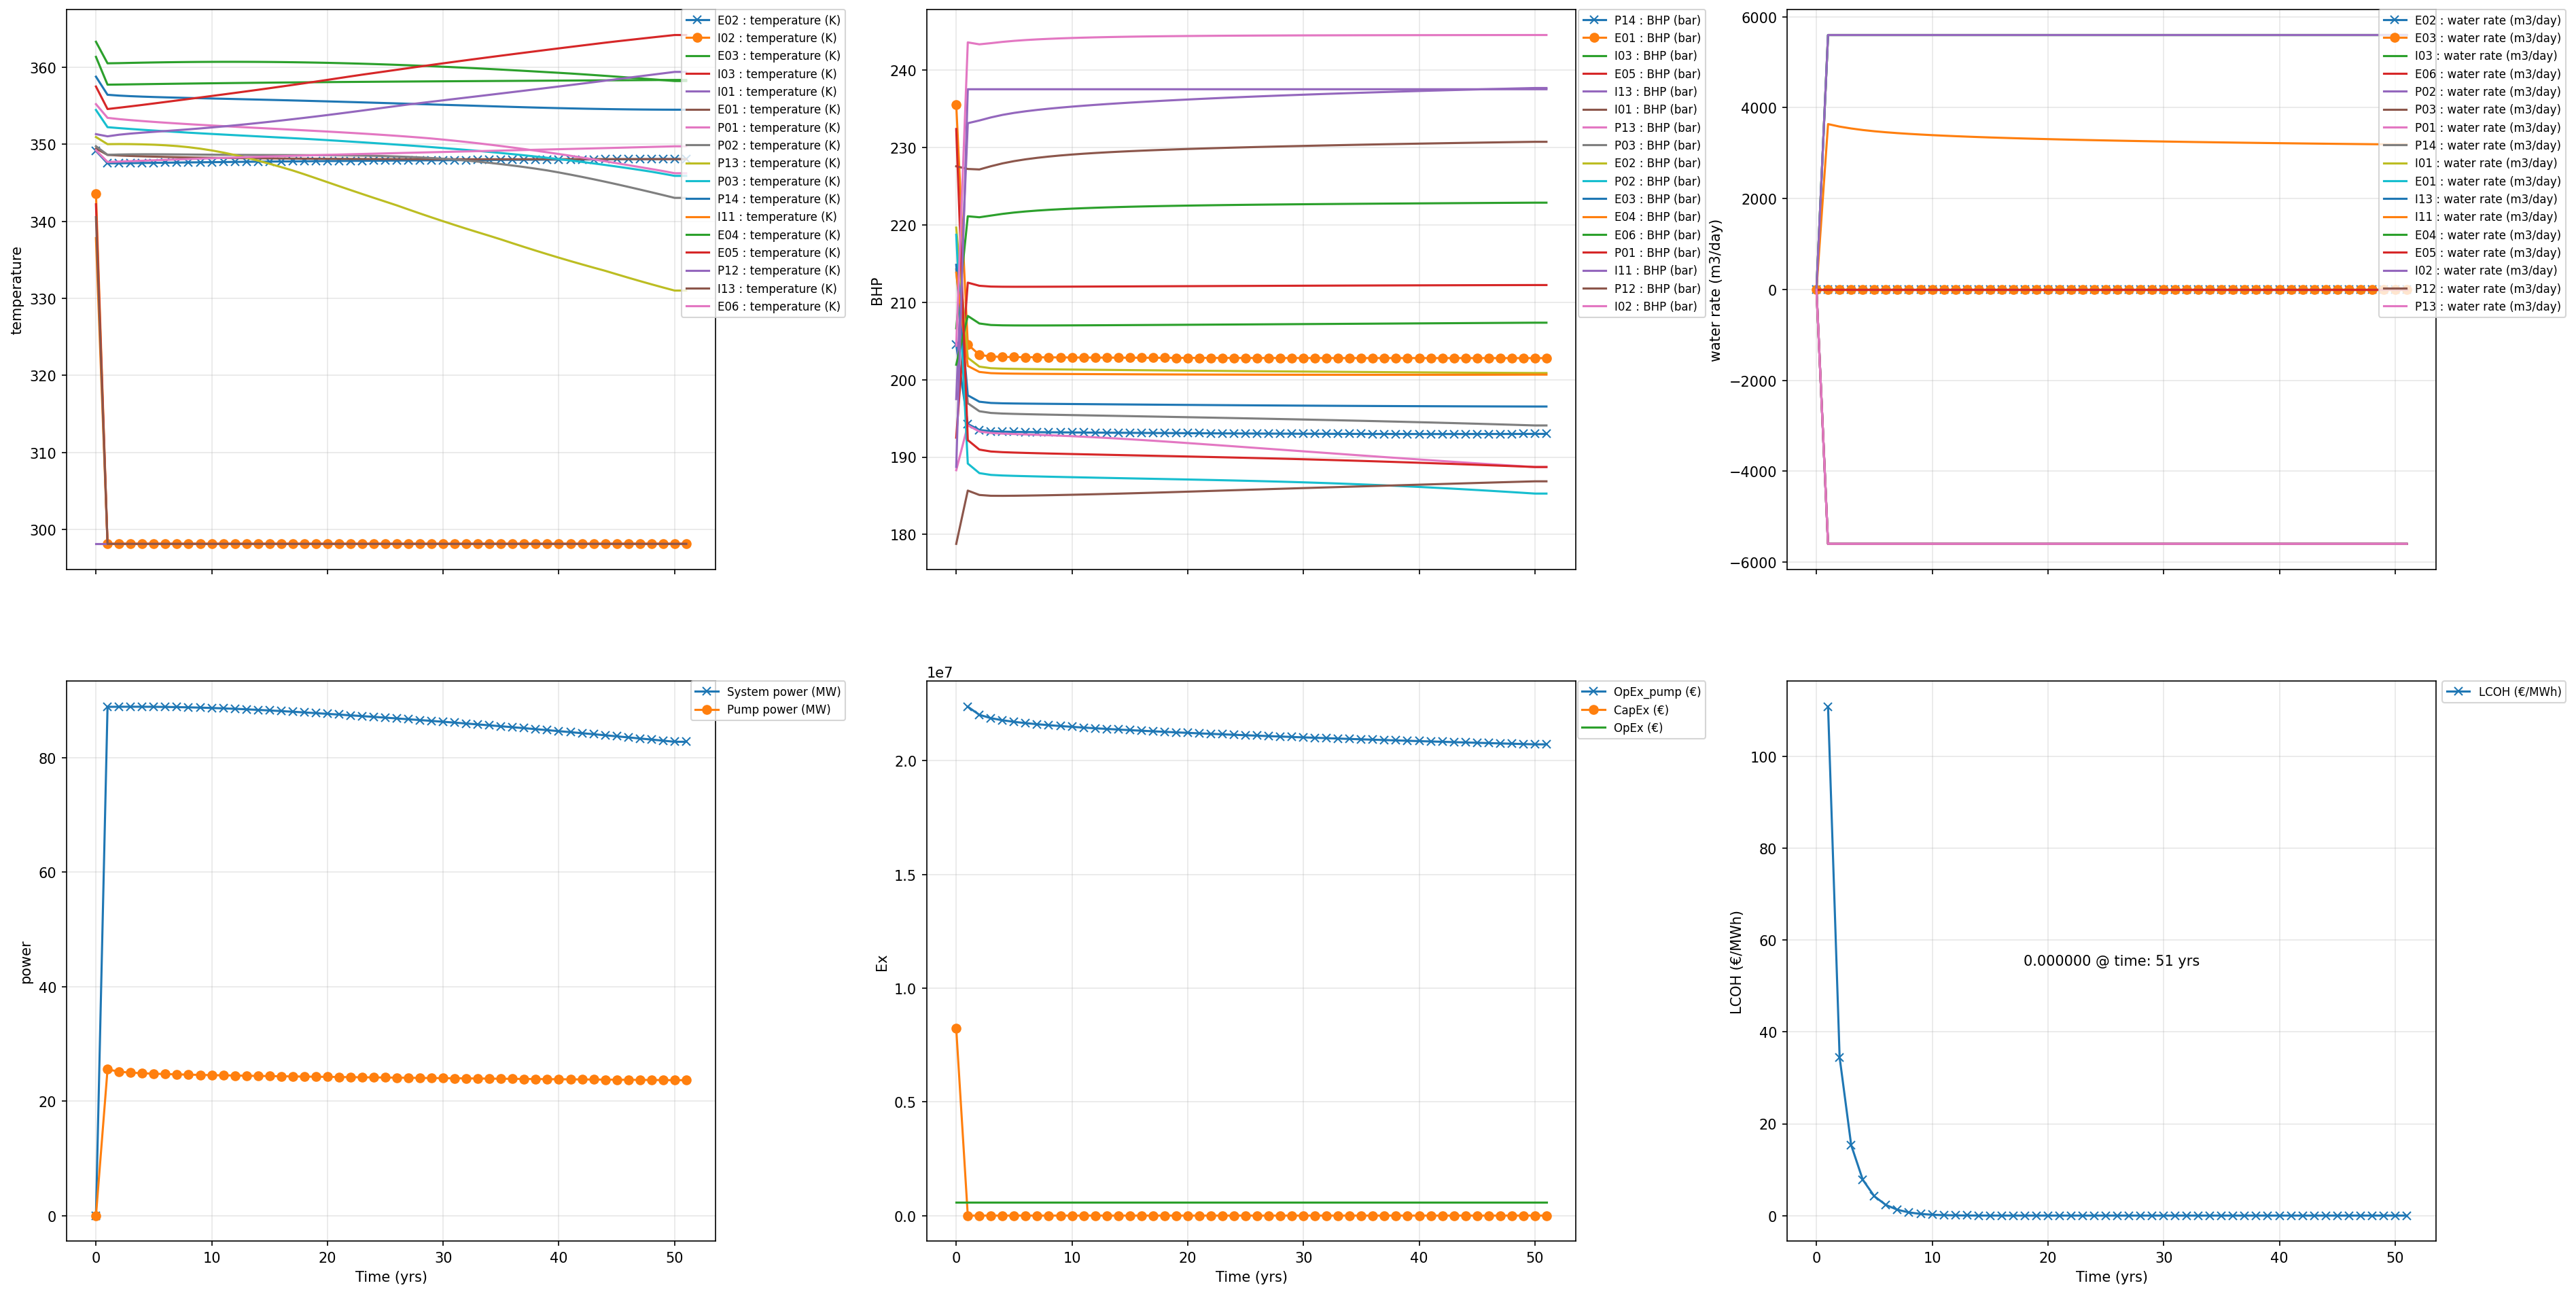

In [143]:
#final plot
# define a plot
fig, ax = plt.subplots(2,3, figsize=(30,16), dpi=150, sharex=True)
# get plot axes
ax_list = fig.axes

# plot a few keywords in pairs for both wells
for i, key in enumerate(['temperature', 'BHP','water rate (m3/day)',
                        'power', 'Ex', 'LCOH (€/MWh)']):
    tdata.plot(x='Time (yrs)',
              y=tdata.filter(like=key).columns.tolist(),
              ylabel=key,
              ax=ax_list[i],
              linestyle='-',
              style=['x', 'o'],
              fontsize=10
             )
    plt.subplots_adjust(wspace=0.325)
    ax_list[i].legend(fontsize=8, bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0.)
    ax_list[i].grid(alpha=0.3)
    if key == 'LCOH (€/MWh)':
        ax_list[i].annotate('%0.6f @ time: %0.0f yrs' % (tdata[key].iloc[-1], tdata['Time (yrs)'].iloc[-1]),
                           xy=(0.5, 0.5), va='center', ha='center',
                           xycoords=('axes fraction'))
plt.savefig('operation.png', format='png', bbox_inches='tight')
# plt.show()

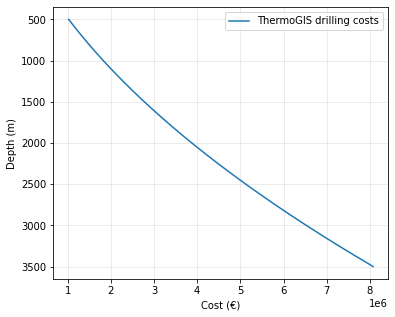

In [139]:
def drillingcostnl(depth):
    """
    Calculate the cost of drilling as a function of depth
    Reference source:
        http://www.thermogis.nl/en/economic-model
        
    :param depth: float
        measured depth along hole in meters
    
    :return: float
        costs in euros
    """
    drilling_cost_nl = 375000 + 1150 * depth + 0.3 * depth ** 2
    return(drilling_cost_nl)

depth = np.arange(500,3500, 1)
costs = drillingcostnl(depth)

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(costs, depth, label='ThermoGIS drilling costs')
ax.set_xlabel('Cost (€)')
ax.set_ylabel('Depth (m)')
ax.grid(alpha=0.3)
ax.legend()
ax.invert_yaxis()

## Each well must be individually connected to the demand side